# Procesamiento de datos

Importa librerías necesarias para análisis de datos y manejo de archivos.

In [54]:
import pandas as pd
import numpy as np
import glob

Buscar todos los archivos CSV en la carpeta "datasets" y carga todos los CSV en una lista de DataFrames, ignorando líneas problemáticas

In [55]:
archivos = glob.glob("datasets/*.csv")

print("Archivos encontrados:")
for f in archivos:
    print(f)

dataframes = []
for f in archivos:
    try:
        df = pd.read_csv(f, on_bad_lines='skip')
        dataframes.append(df)
    except Exception as e:
        print(f"Error al leer {f}: {e}")


Archivos encontrados:
datasets\API_EN.GHG.FGAS.IP.MT.CE.AR5_DS2_es_csv_v2_75297.csv
datasets\API_ER.H2O.FWTL.ZS_DS2_es_csv_v2_49721.csv
datasets\API_FB.BNK.CAPA.ZS_DS2_es_csv_v2_35034.csv
datasets\API_SH.STA.SMSS.ZS_DS2_es_csv_v2_55700.csv
datasets\OWID_CB.csv
datasets\points_data.csv
datasets\WDPA_WDOECM_Aug2025_Public_HND_csv.csv


Limpieza básica de un DataFrame:
    1. Eliminar duplicados
    2. Rellenar valores nulos (texto → 'desconocido', numéricos → mediana)
    3. Convertir columnas con 'fecha' a tipo datetime

In [56]:
def limpieza_basica(df):
    df = df.drop_duplicates()

    for col in df.columns:
        if df[col].dtype == "object":
            df[col] = df[col].fillna("desconocido").str.strip().str.lower()


    for col in df.columns:
        if "fecha" in col.lower():
            df[col] = pd.to_datetime(df[col], errors="coerce")
    
    return df


 Aplicar limpieza a cada DataFrame cargado y mostrar comparativa de filas

In [57]:
dataframes_limpios = []

for archivo, df in zip(archivos, dataframes):
    df_limpio = limpieza_basica(df)
    dataframes_limpios.append(df_limpio)
    print(f"{archivo} -> Filas originales: {df.shape[0]}, Filas limpias: {df_limpio.shape[0]}")


datasets\API_EN.GHG.FGAS.IP.MT.CE.AR5_DS2_es_csv_v2_75297.csv -> Filas originales: 266, Filas limpias: 266
datasets\API_ER.H2O.FWTL.ZS_DS2_es_csv_v2_49721.csv -> Filas originales: 266, Filas limpias: 266
datasets\API_FB.BNK.CAPA.ZS_DS2_es_csv_v2_35034.csv -> Filas originales: 266, Filas limpias: 266
datasets\API_SH.STA.SMSS.ZS_DS2_es_csv_v2_55700.csv -> Filas originales: 266, Filas limpias: 266
datasets\OWID_CB.csv -> Filas originales: 3079976, Filas limpias: 3079976
datasets\points_data.csv -> Filas originales: 1375, Filas limpias: 1375
datasets\WDPA_WDOECM_Aug2025_Public_HND_csv.csv -> Filas originales: 119, Filas limpias: 119


Crear carpeta "data_limpios" y guardar allí los DataFrames limpios

In [58]:
import os
os.makedirs("data_limpios", exist_ok=True)


for archivo, df in zip(archivos, dataframes_limpios):
    nombre = os.path.basename(archivo)  # nombre del archivo original
    df.to_csv(os.path.join("data_limpios", f"limpio_{nombre}"), index=False)

print("Archivos limpios guardados en carpeta 'data_limpios'")


Archivos limpios guardados en carpeta 'data_limpios'


# Aplicacion de Tecnicas de analisis de datos

Importar librerías de visualización y configurar estilo gráfico.

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

Seleccionar algunos archivos limpios específicos para análisis

In [60]:
archivos = [
    "data_limpios/limpio_API_ER.H2O.FWTL.ZS_DS2_es_csv_v2_49721.csv",
    "data_limpios/limpio_API_FB.BNK.CAPA.ZS_DS2_es_csv_v2_35034.csv",
    "data_limpios/limpio_API_EN.GHG.FGAS.IP.MT.CE.AR5_DS2_es_csv_v2_75297.csv",
    "data_limpios/limpio_API_SH.STA.SMSS.ZS_DS2_es_csv_v2_55700.csv"
]

dataframes = [pd.read_csv(f) for f in archivos]


Transformar DataFrame de formato ancho a largo:
    - Mantener columnas de identificación (país, indicador)
    - Convertir años en columna "Year"
    - Valores en columna "Value"

In [61]:
def transformar(df):
    df_long = df.melt(
        id_vars=["Country Name", "Country Code", "Indicator Name", "Indicator Code"],
        var_name="Year",
        value_name="Value"
    )
    df_long["Year"] = pd.to_numeric(df_long["Year"], errors="coerce")
    return df_long[df_long["Country Name"] == "honduras"]

dataframes_long = [transformar(df) for df in dataframes]



Gráfico de tendencia global para los csv

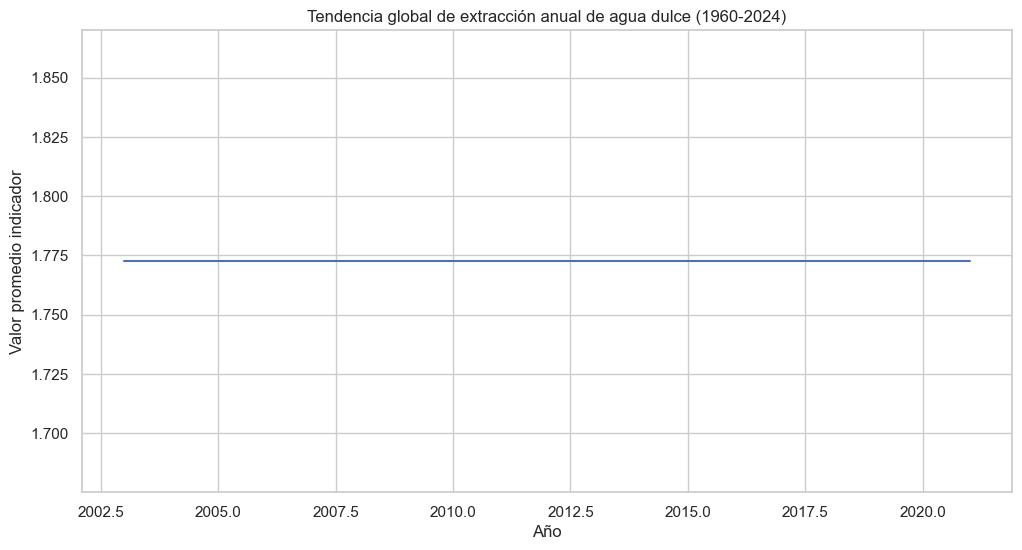

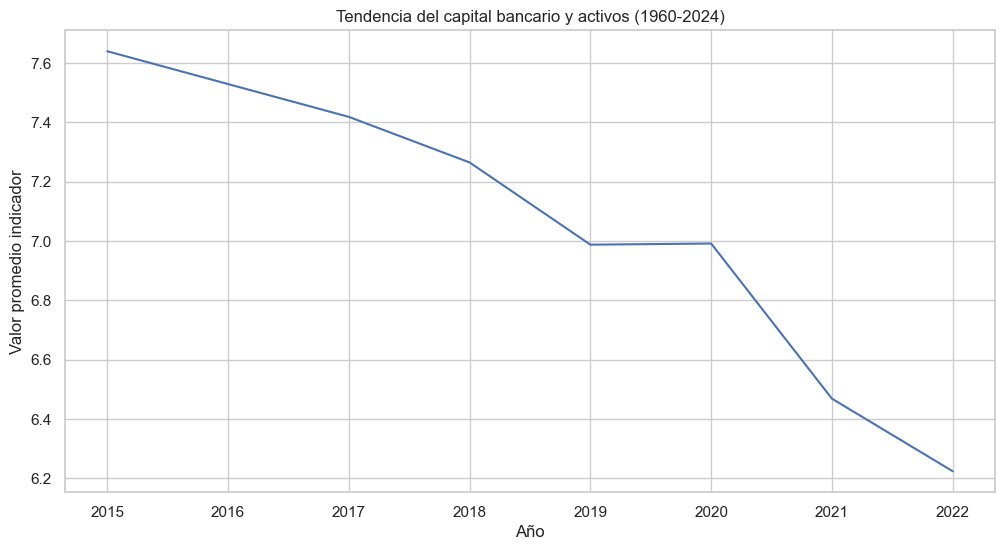

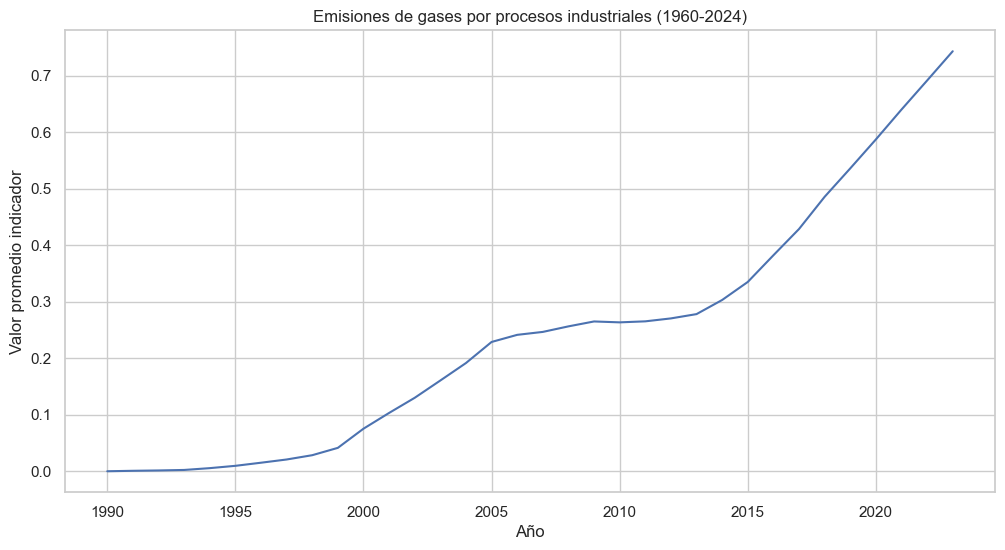

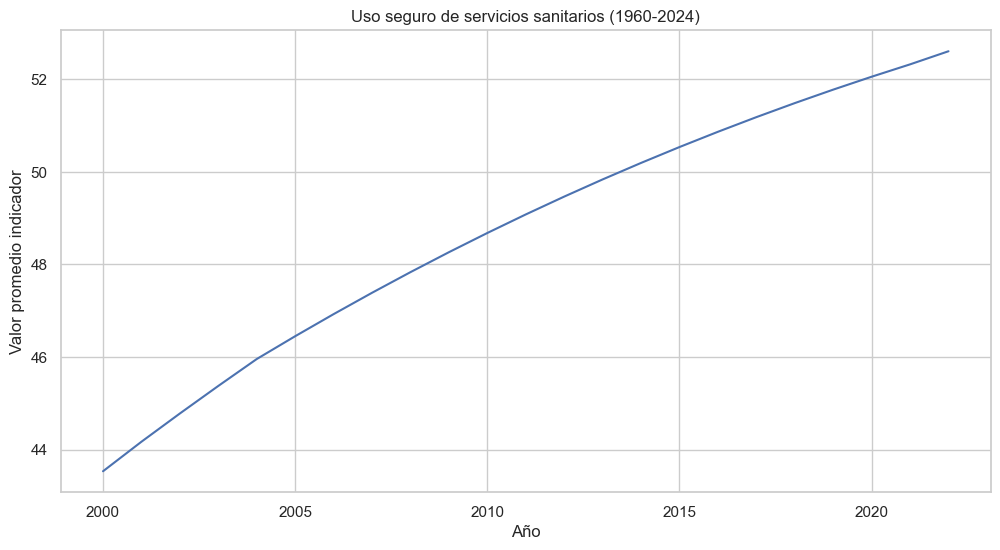

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Títulos para cada dataframe
titulos = {
    0: "Tendencia global de extracción anual de agua dulce (1960-2024)",
    1: "Tendencia del capital bancario y activos (1960-2024)",
    2: "Emisiones de gases por procesos industriales (1960-2024)",
    3: "Uso seguro de servicios sanitarios (1960-2024)"
}

# Recorrer cada dataframe y graficar
for i, df in enumerate(dataframes_long):
    trend = df.groupby("Year")["Value"].mean().reset_index()
    
    plt.figure(figsize=(12,6))
    sns.lineplot(data=trend, x="Year", y="Value")
    plt.title(titulos[i])
    plt.ylabel("Valor promedio indicador")
    plt.xlabel("Año")
    plt.show()


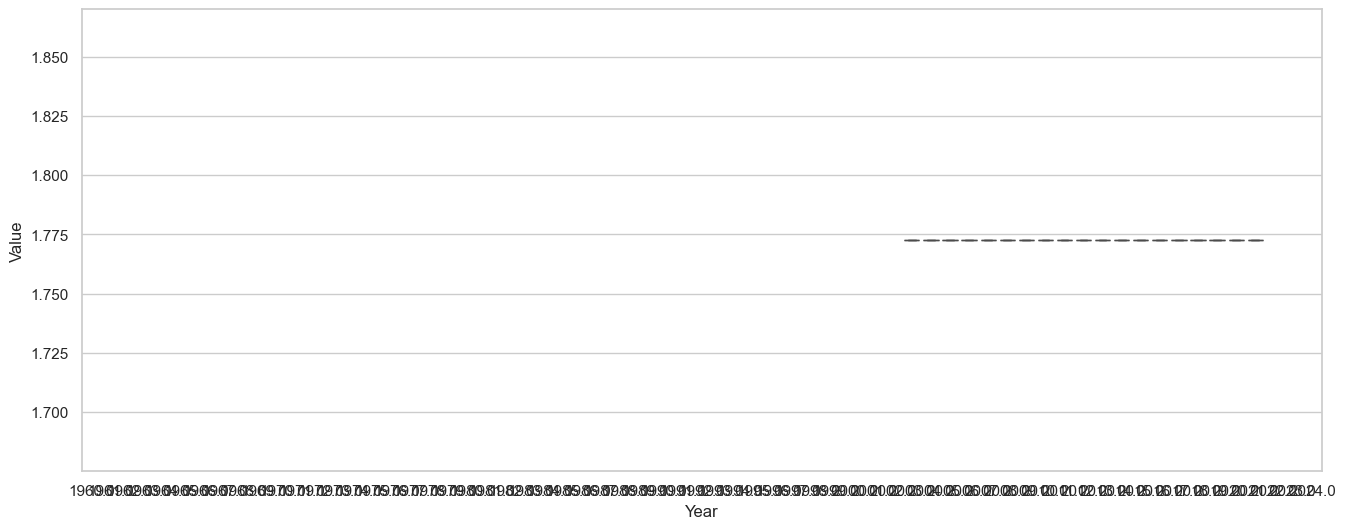

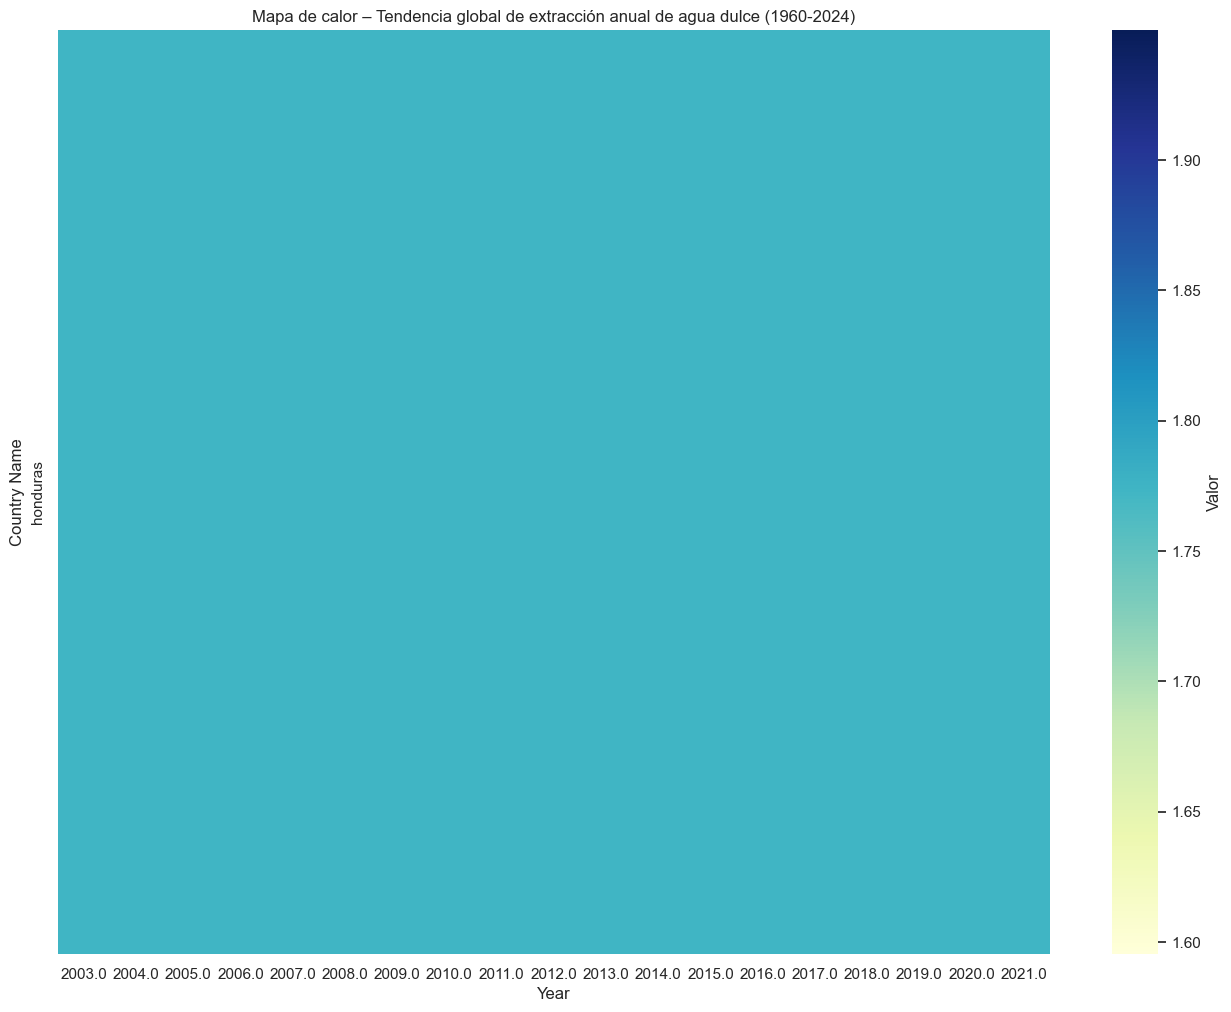

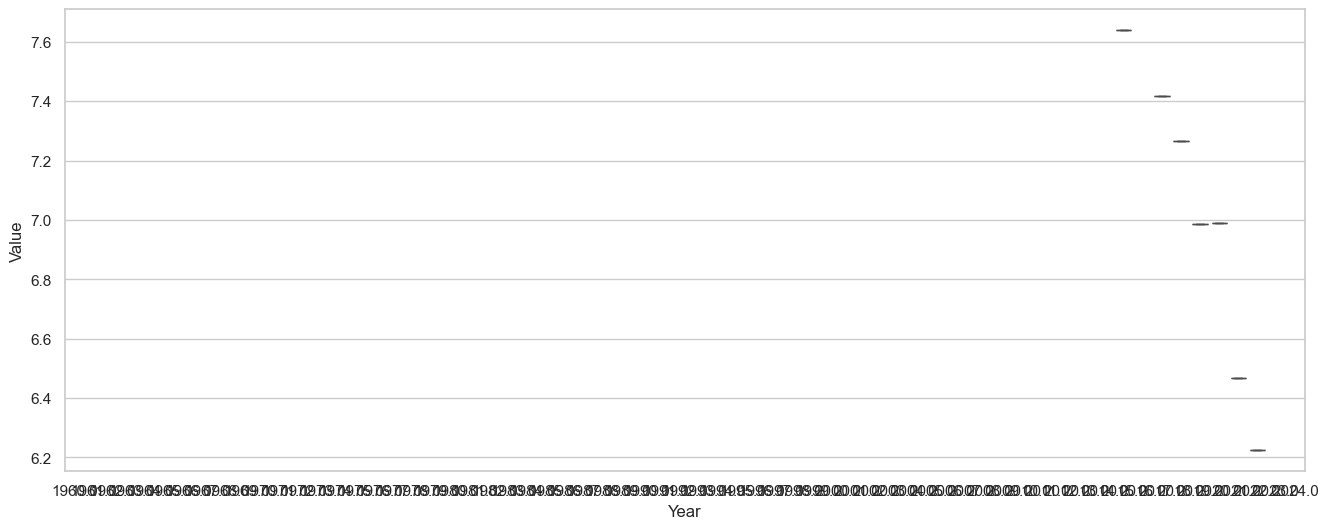

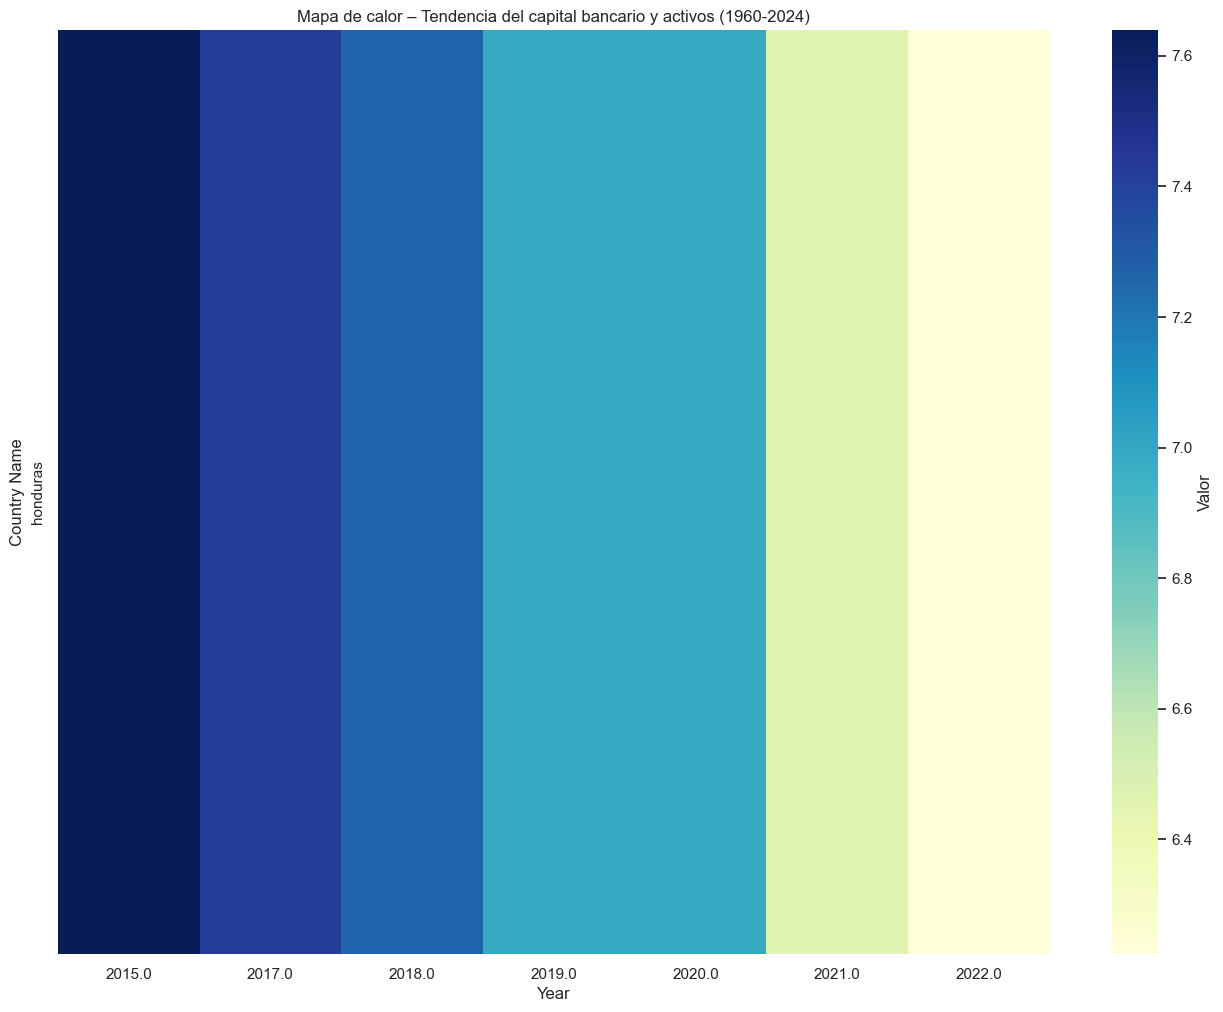

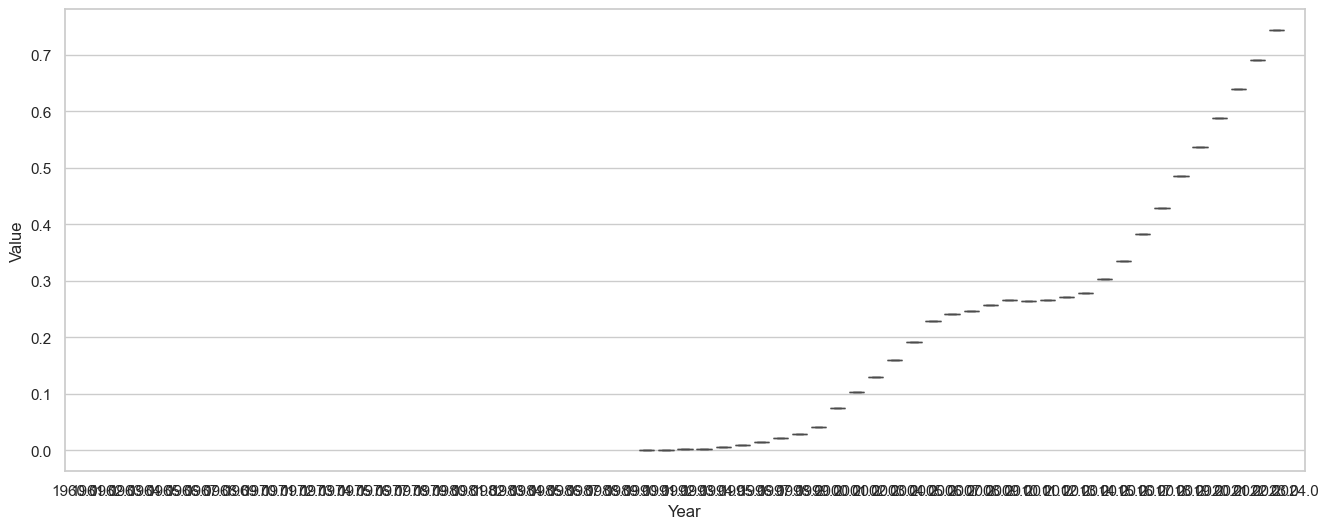

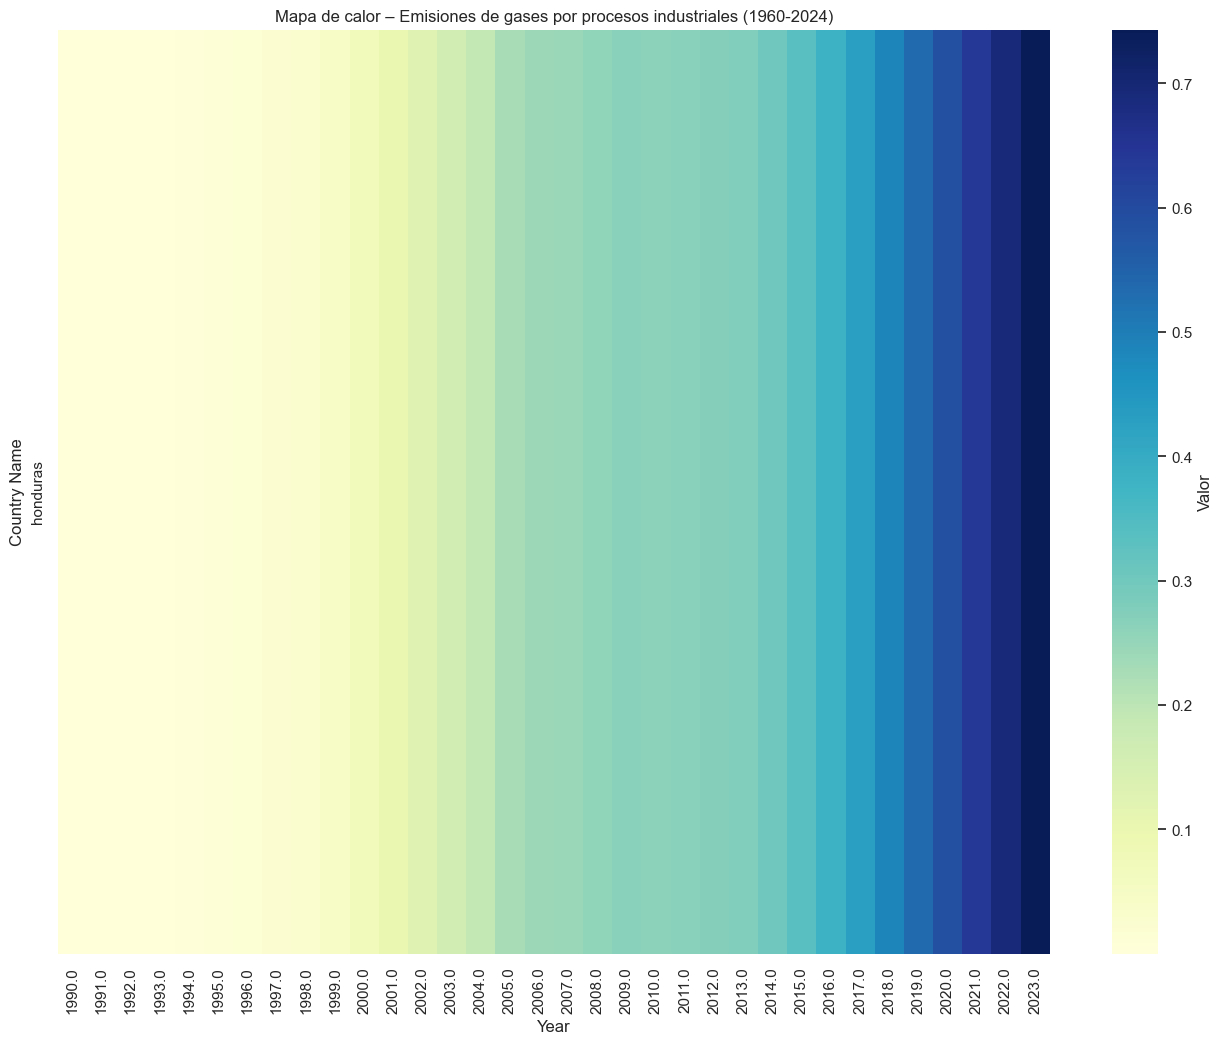

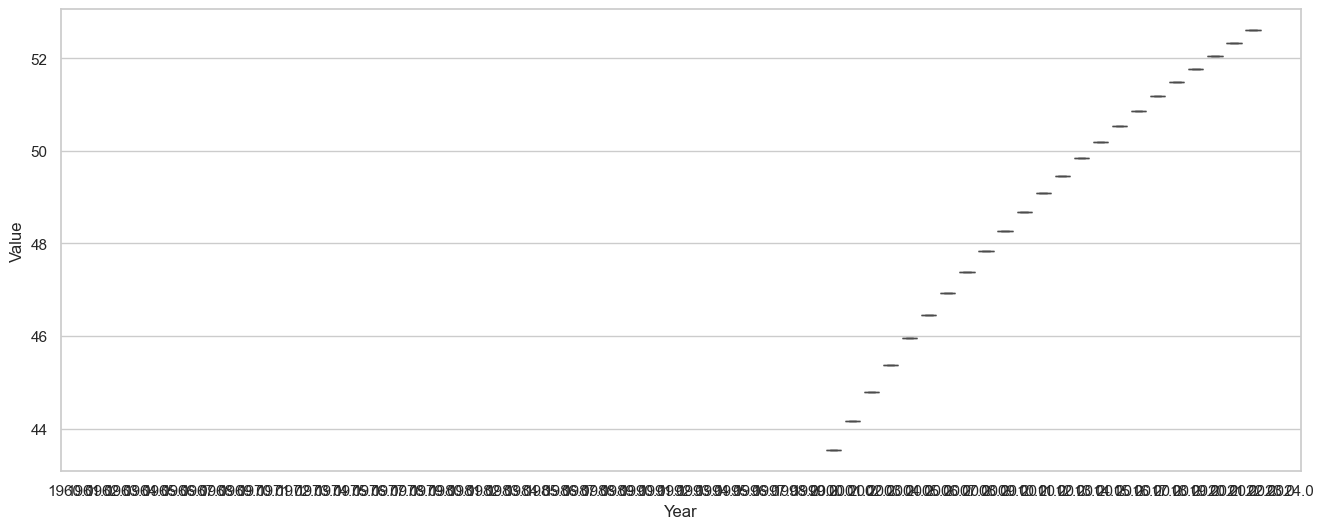

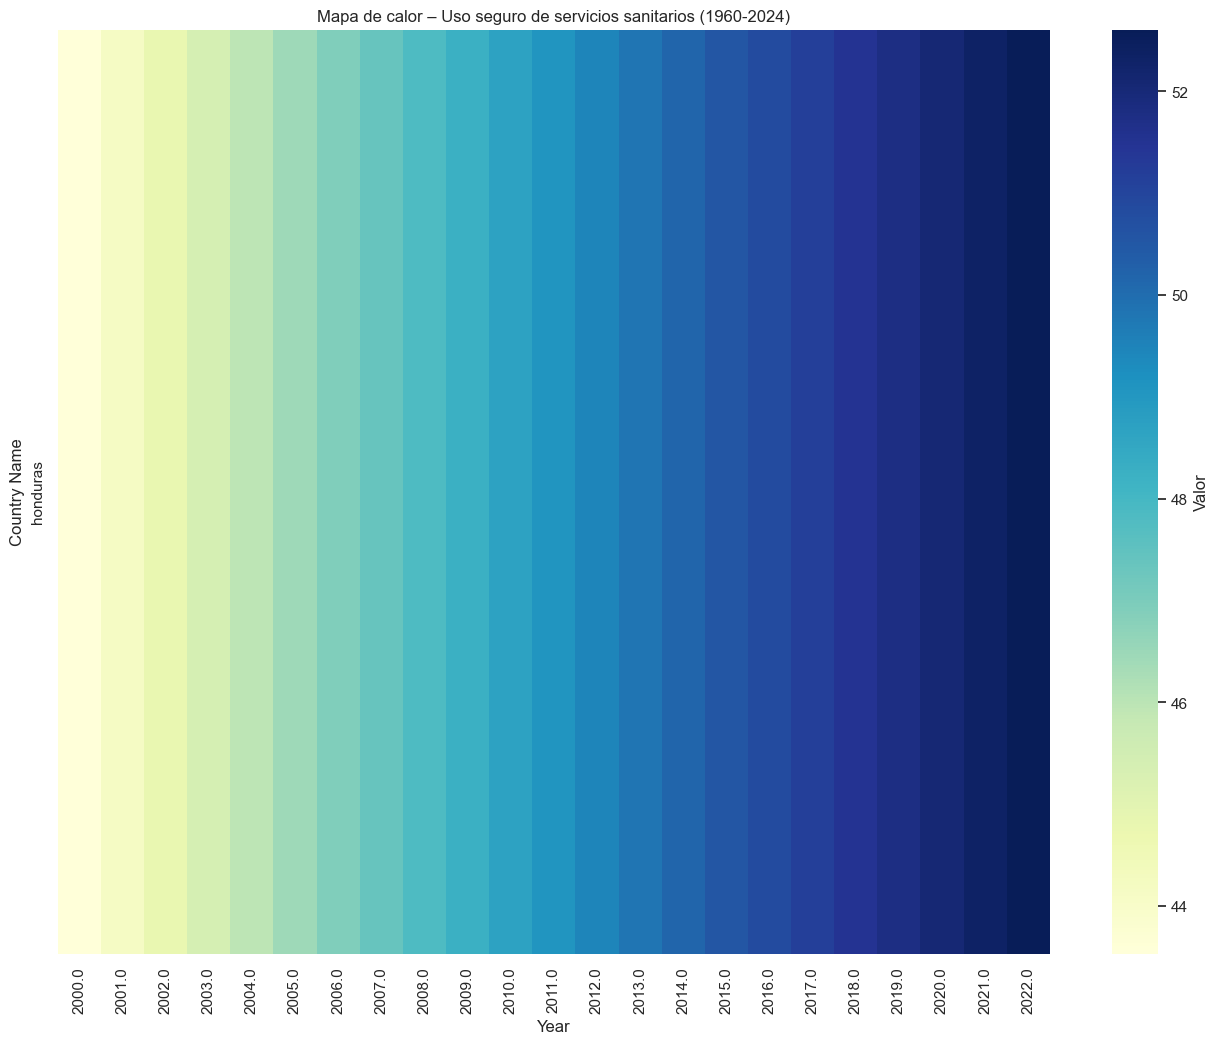

In [65]:
years = np.arange(1960, 2025) 

for i, df in enumerate(dataframes_long):
    plt.figure(figsize=(16,6))
    
    # Filtramos los años que tenemos en el rango
    df_plot = df[df["Year"].between(1960, 2024)]
    
    sns.boxplot(data=df_plot, x="Year", y="Value")
    pivot = df_plot.pivot_table(index="Country Name", columns="Year", values="Value")
    plt.figure(figsize=(16,12))
    sns.heatmap(pivot, cmap="YlGnBu", cbar_kws={'label': 'Valor'})
    plt.title(f"Mapa de calor – {titulos[i]}")
    plt.show()

# Modelo Predictivos

Ejemplo de modelo predictivo para un país específico (Brasil)

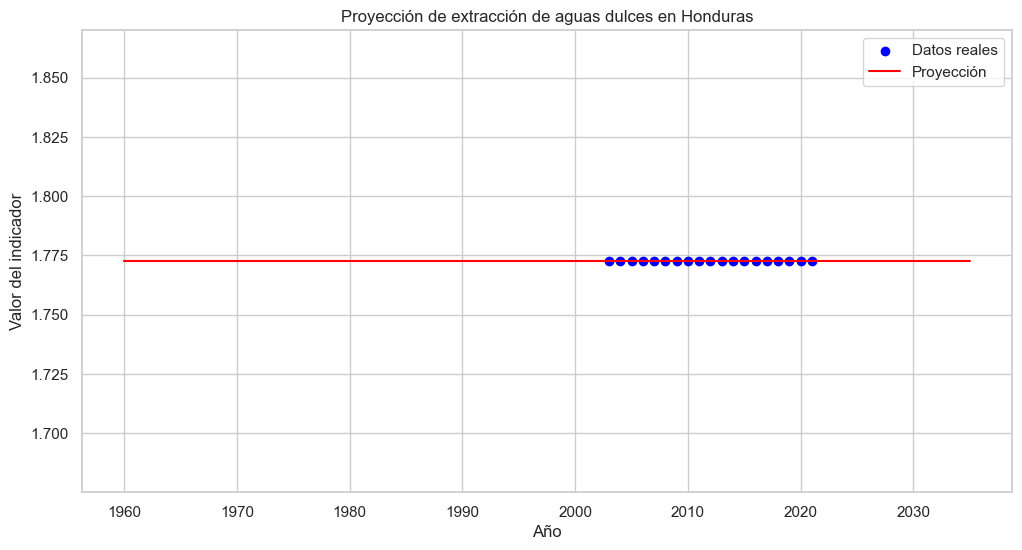

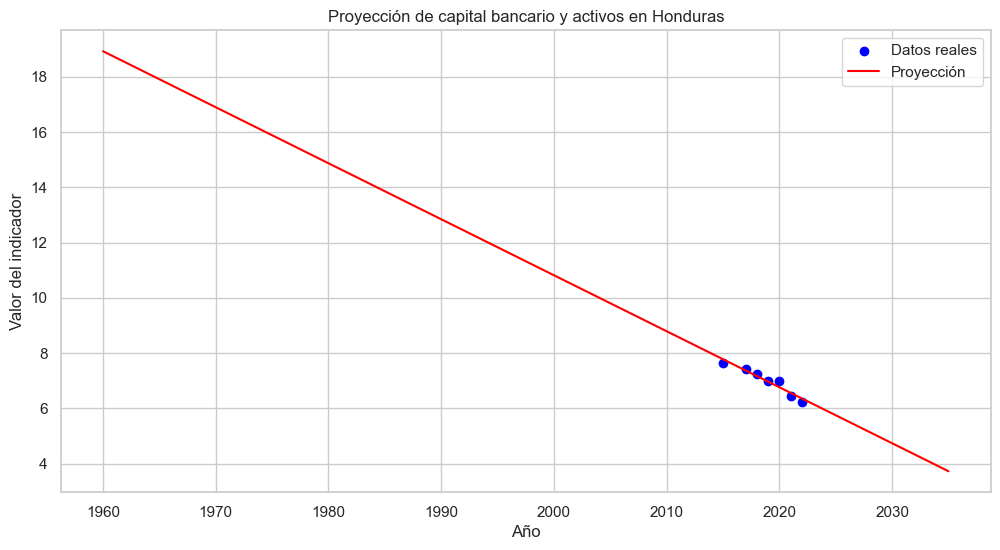

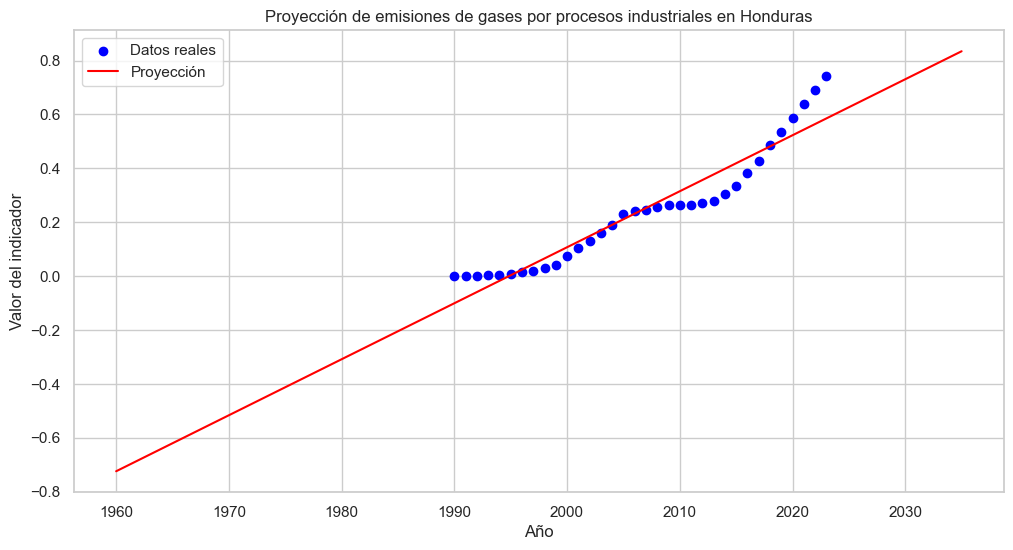

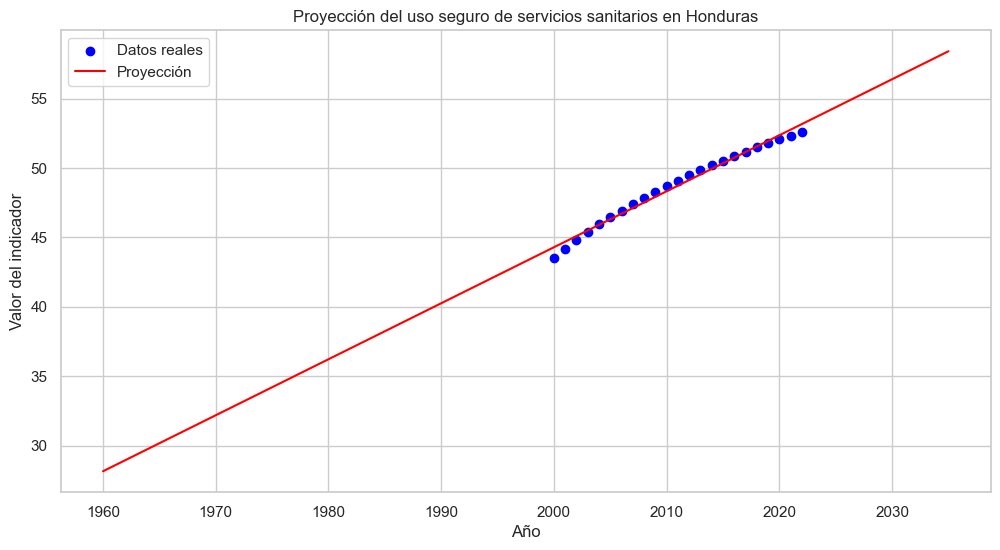

In [66]:
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

# Diccionario de títulos
titulos = {
    0: "Proyección de extracción de aguas dulces",
    1: "Proyección de capital bancario y activos",
    2: "Proyección de emisiones de gases por procesos industriales",
    3: "Proyección del uso seguro de servicios sanitarios"
}

pais = "honduras"  # << Aquí cambias el país que quieras

for i, df in enumerate(dataframes_long):
    df_pais = df[df["Country Name"] == pais].dropna(subset=["Value"])
    
    if df_pais.empty:
        print(f"No hay datos disponibles para {pais} en el indicador {i}")
        continue
    
    X = df_pais["Year"].values.reshape(-1,1)
    y = df_pais["Value"].values

    # Entrenar modelo
    model = LinearRegression()
    model.fit(X, y)

    # Proyectar hasta 2035
    future_years = np.arange(1960, 2036).reshape(-1,1)
    y_pred = model.predict(future_years)

    # Visualización
    plt.figure(figsize=(12,6))
    plt.scatter(X, y, label="Datos reales", color="blue")
    plt.plot(future_years, y_pred, color="red", label="Proyección")
    plt.title(f"{titulos[i]} en {pais.capitalize()}")
    plt.xlabel("Año")
    plt.ylabel("Valor del indicador")
    plt.legend()
    plt.show()
